### Abstract

This notebook is a demonstration on how to do time-series prediction with ARIMA model. It is inspired by the blog from [machinelearningmastery.com](http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).


In [47]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

#### Dataset

The [time-series dataset](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line) is sales of shampoo over a three year peroid.

In [10]:
!ls *.csv
!head shampoo-sales.csv

shampoo-sales.csv
"Month","Sales"
"1-01",266.0
"1-02",145.9
"1-03",183.1
"1-04",119.3
"1-05",180.3
"1-06",168.5
"1-07",231.8
"1-08",224.5
"1-09",192.8


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


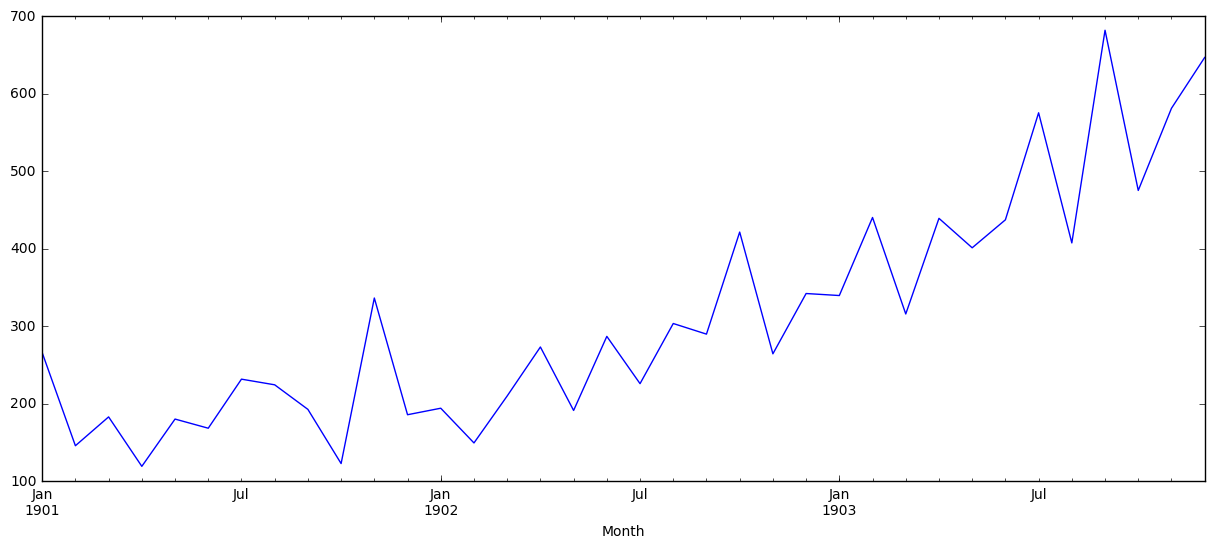

In [15]:
def parser(x):
    # add the year prefix 1900.
    return pd.datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('shampoo-sales.csv',
                     header=0, parse_dates=[0], index_col=0,
                     squeeze=True, date_parser=parser)

print(series.head())

_ = series.plot()

From the above graph, we could see an overall *trend* in the sales. Therefore, it is necessary to detrend the dataset in order to fit the ARIMA model.

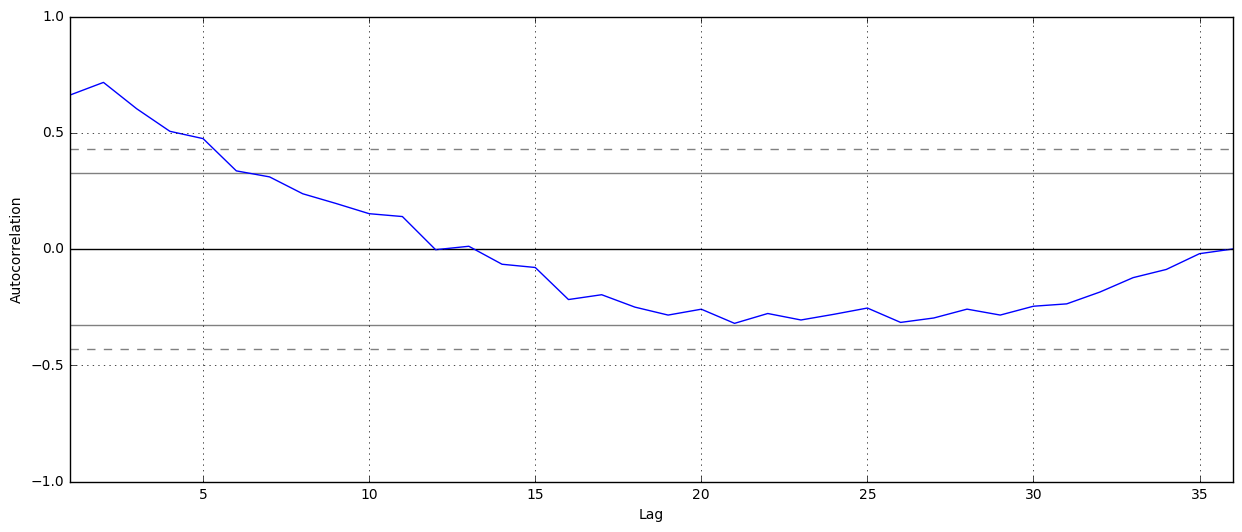

In [13]:
from pandas.tools.plotting import autocorrelation_plot

_ = autocorrelation_plot(series)

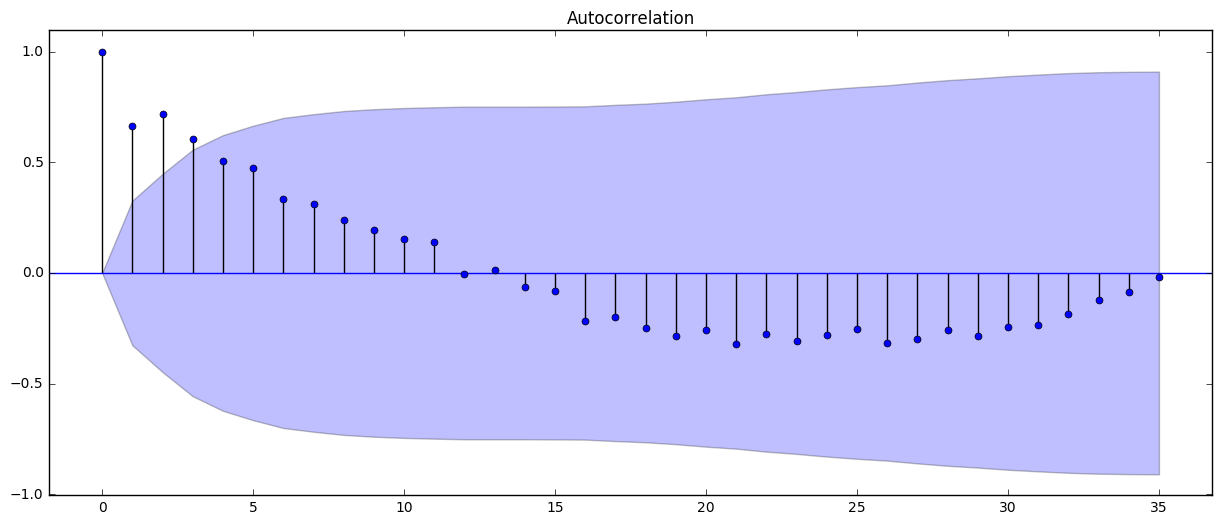

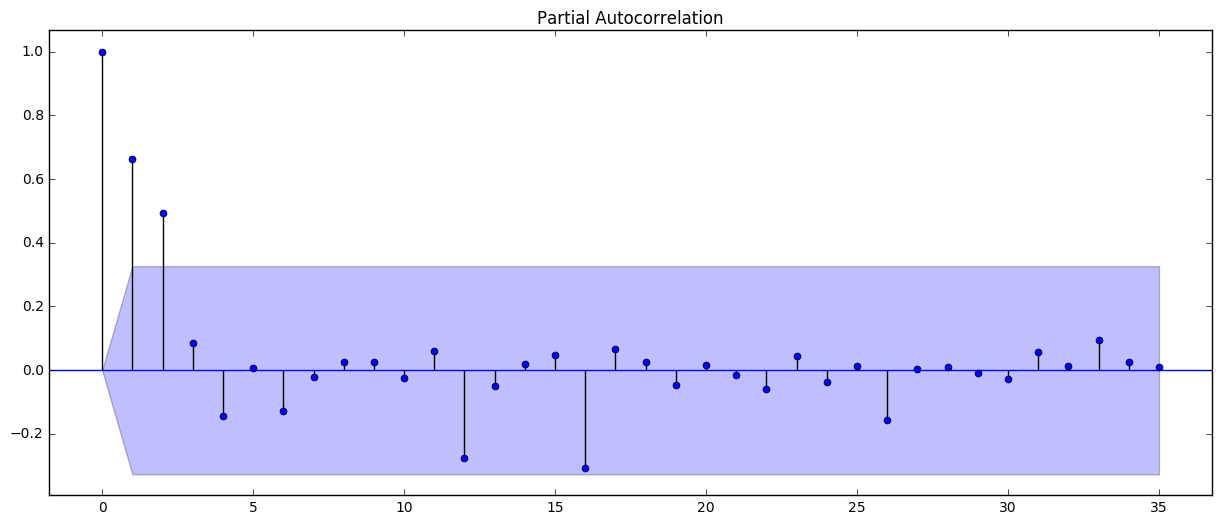

In [23]:
from statsmodels.graphics import utils, tsaplots
from statsmodels.tsa.stattools import acf, pacf

_ = tsaplots.plot_acf(series)
_ = tsaplots.plot_pacf(series)

One can get some hints on the orders (parameter, `p`, `d`, `q`) of ARIMA from the autocorrelation and partial autocorrelation plots.

In [26]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Mon, 10 Apr 2017   AIC                            406.340
Time:                        11:43:30   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003         4.908    19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000        -1.466    -0.750
ar.L2.D.Sales    -0.6203      0.282     

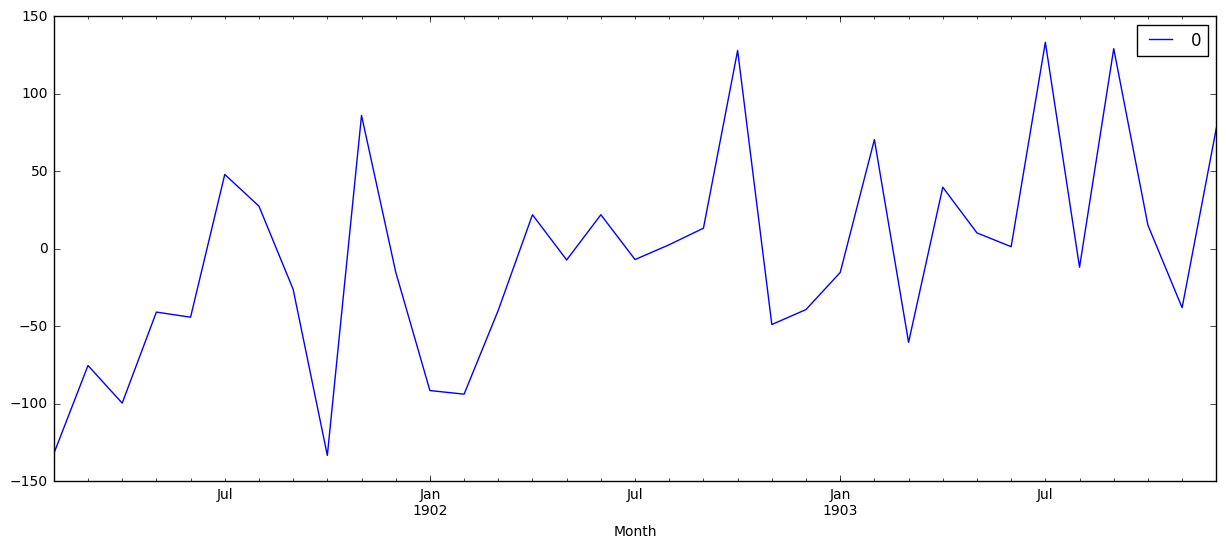

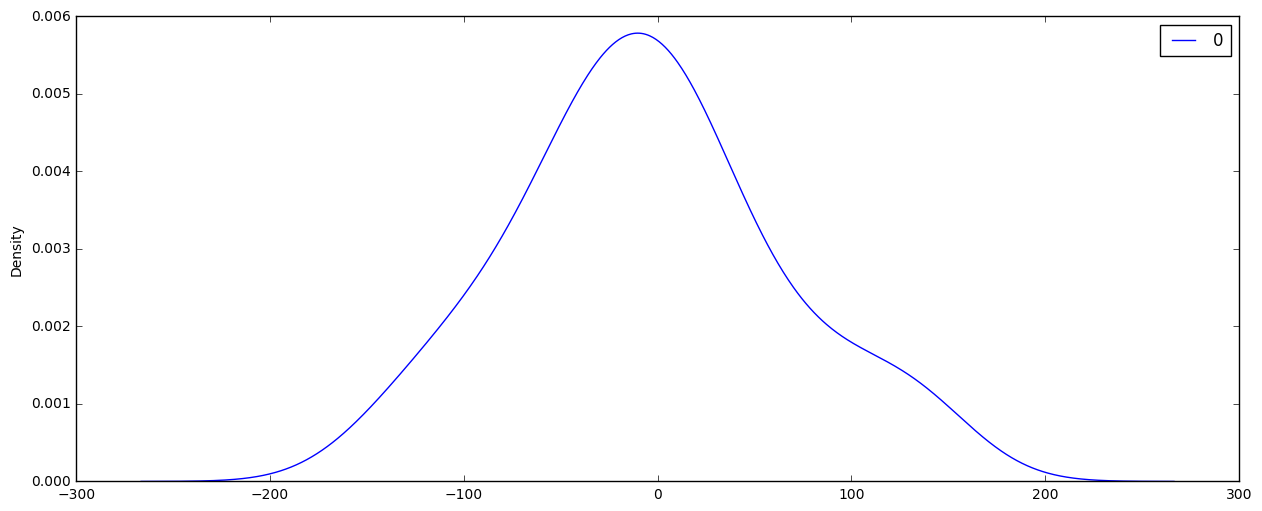

In [32]:
residuals = pd.DataFrame(model_fit.resid)
_ = residuals.plot()

_ = residuals.plot(kind='kde')

#### Rolling Forecast 

Split the data into training and test datasets, use the data from the training dataset to predict the first value in the test data set, then update the training set for the next value in the test data.

In [43]:
# Split the dataset
split = int(len(series) * 0.66)
train, test = series[0:split], series[split:]

history = [x for x in train.values]
prediction = list()

for t in range(len(test)):
    # train and predict with the existing historical data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    # add the new prediction
    prediction.append(yhat)
    # prepare for the next round
    history.append(test[t])
    print('predictd=%f, expected=%f' % (yhat, test[t]))

predictd=349.117670, expected=342.300000
predictd=306.513018, expected=339.700000
predictd=387.376436, expected=440.400000
predictd=348.154143, expected=315.900000
predictd=386.308839, expected=439.300000
predictd=356.082073, expected=401.300000
predictd=446.379398, expected=437.400000
predictd=394.737322, expected=575.500000
predictd=434.915461, expected=407.600000
predictd=507.923373, expected=682.000000
predictd=435.483072, expected=475.300000
predictd=652.743752, expected=581.300000
predictd=546.343468, expected=646.900000


Test MSE: 6958.323392


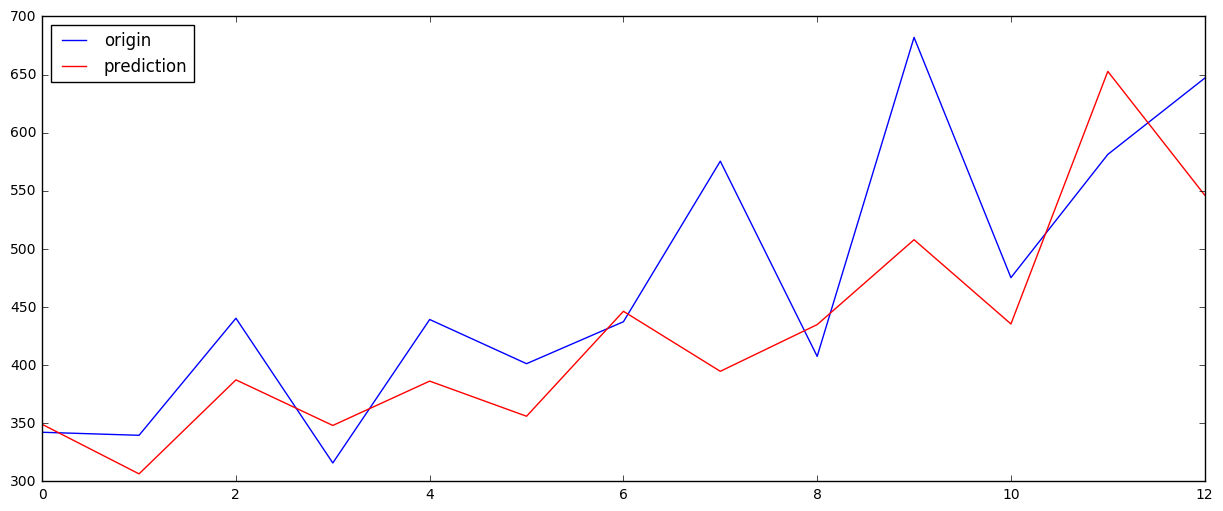

In [59]:
from sklearn.metrics import mean_squared_error

print('Test MSE: %f' % mean_squared_error(test, prediction))

ax = plt.subplot(111)
ax.plot(test.values, label='origin')
_ = ax.plot(prediction, color='red', label='prediction')

plt.legend(loc='best')